<a href="https://colab.research.google.com/github/carlosmanm/Data_Science/blob/main/Python_Fundamentals/Independent_Projects/Back_to_Office/Back_to_Office_COVID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Return to Office - for X groups

# Description of the tool

Design of a solution that, based on certain key characteristics of employees, calibrators and internal constraints, can indicate the Waves/Phases that indicate how the segments are being incorporated into the office. 

In other words... Given the current characteristics of the base and the calibrators, the number of people that can be incorporated into the office are...X

And the next group would be...

And the next would be...

# Key Indicators

* Vulnerable Group

* Organizational Requirement

* Age

* Transportation

* Vaccination

* Children 17 years old or younger


* Gauges

* Government Indicator: That is, the capacity allowed by the government.
* Safe Capacity: This is relative to the Government Indicator and is -10% of what the Government indicates.
* Schools

What is sought is that, the result indicates the amount of people (or group of people) that can return to the office is this. 

In addition, this result should be indicated by Building and by Company.

Note: In addition, a return in intervals of 20% (preferably no more and no less) is expected.

# Internal Restrictions

Floor 8 - 3%

Floor 7 - 21%

Floor 6 - 26% 

Floor 5 - 24%



In [ ]:
pip install xlsxwriter

     |████████████████████████████████| 149 kB 7.6 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats
import seaborn as sns

import statsmodels.api as sm
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from numpy import asarray
from sklearn.preprocessing import StandardScaler
from google.colab import files

from tabulate import tabulate

%matplotlib inline

In [ ]:
from IPython.display import display, HTML

CSS = """
.output {
  flex-direction: row;
}
"""
HTML ('<style>{}</style>'.format(CSS))

# Loading the data


In [ ]:
data = pd.read_excel("V2_Base_BAL.xlsm", sheet_name="v2BaseRH", header=1)

In [ ]:
data.head()

,ID,Empresa,Área,Nivel Organizacional,Fecha de Nacimiento,Vulnerable,Requerimiento Organizacional,Sexo,Transporte,Hijos de 0 a 17 años,Vacunación,Edad,Embarazo,Piso,Tipo de estación,Lap top,Estatus,Criterio de reincorporación,Score
0,1,AOSA,COMEDORES,Secretaria,1964-11-02 00:00:00,0,Presencial,F,Si,0,Si,56.0,No,PB,Abierta,Si,En Oficina,3,3
1,2,AOSA,ASESORES,Secretaria,1975-06-05 00:00:00,0,Presencial,F,Si,0,No,46.0,No,PB,Abierta,Si,En Oficina,3,3
2,3,AOSA,CUMPLIMIENTO CORPORATIVO,Secretaria,1971-09-29 00:00:00,0,Presencial,F,Si,0,No,49.0,No,PB,Abierta,Si,En Oficina,3,3
3,4,MOLIERE,ADMINISTRADORA MOLIERE,No Profesionista,NaN,0,Presencial,M,Si,0,No,NaN,No,PB,Abierta,NaN,En Oficina,2,2
4,5,AOSA,HOLDINGS,Secretaria,1973-09-11 00:00:00,0,Presencial,F,Si,1,No,47.0,No,Piso 5,Abierta,Si,En Oficina,3,3


# First look at the data

In [ ]:
data.columns

Index(['ID', 'Empresa', 'Área', 'Nivel Organizacional', 'Fecha de Nacimiento',
       'Vulnerable', 'Requerimiento Organizacional', 'Sexo', 'Transporte',
       'Hijos de 0 a 17 años', 'Vacunación', 'Edad', 'Embarazo ', 'Piso',
       'Tipo de estación', 'Lap top', 'Estatus', 'Criterio de reincorporación',
       'Score'],
      dtype='object')

In [ ]:
data.describe()

,ID,Vulnerable,Hijos de 0 a 17 años,Edad
count,354.000000,354.000000,354.000000,326.000000
mean,182.997175,0.135593,0.429379,42.889571
std,106.950374,0.342841,0.746540,12.631587
min,1.000000,0.000000,0.000000,22.000000
25%,90.250000,0.000000,0.000000,32.250000
50%,181.500000,0.000000,0.000000,41.000000
75%,271.750000,0.000000,1.000000,51.750000
max,368.000000,1.000000,4.000000,92.000000


In [ ]:
data['Empresa'].value_counts()

AOSA         154
TABAL        110
PETROBAL      33
GRUPO BAL     31
MOLIERE       26
Name: Empresa, dtype: int64

In [ ]:
data['Piso'].value_counts()

Piso 6      92
Piso 5      84
PB          77
Piso 7      74
Sótano 2    17
Piso 8      10
Name: Piso, dtype: int64

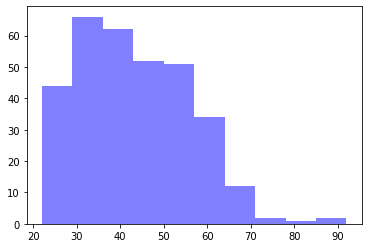

In [ ]:
plt.hist(data["Edad"], facecolor='blue', alpha=0.5)
plt.show()

In [ ]:
data.groupby(by='Empresa').Edad.mean()

Empresa
AOSA         40.064935
GRUPO BAL    37.375000
MOLIERE      43.800000
PETROBAL     43.787879
TABAL        46.915094
Name: Edad, dtype: float64

In [ ]:
data["Vacunación"].value_counts()

No    257
Si     96
SI      1
Name: Vacunación, dtype: int64

# Reemplazo de valores repetidos y primeras correcciones en los hallazgos

In [ ]:
data['Vacunación'].replace('SI','Si',inplace=True)

In [ ]:
data["Vacunación"].value_counts()

No    257
Si     97
Name: Vacunación, dtype: int64

In [ ]:
# data["Edad"] = data['Edad'].fillna(np.mean(data["Edad"]))

In [ ]:
np.mean(data["Edad"])

42.88957055214724

# Segmentando los factores clave

In [ ]:
data_targ = data.filter([
       'Vulnerable', 'Requerimiento Organizacional', 'Transporte',
       'Hijos de 0 a 17 años', 'Vacunación', 'Edad'])

In [ ]:
data_targ["Requerimiento_Organizacional"] =data_targ["Requerimiento Organizacional"]
data_targ = data_targ.drop(["Requerimiento Organizacional"], axis=1)

data_targ["Hijos_17años"] =data_targ["Hijos de 0 a 17 años"]
data_targ = data_targ.drop(["Hijos de 0 a 17 años"], axis=1)

data_targ

,Vulnerable,Transporte,Vacunación,Edad,Requerimiento_Organizacional,Hijos_17años
0,0,Si,Si,56.0,Presencial,0
1,0,Si,No,46.0,Presencial,0
2,0,Si,No,49.0,Presencial,0
3,0,Si,No,NaN,Presencial,0
4,0,Si,No,47.0,Presencial,1
...,...,...,...,...,...,...
349,0,Si,No,NaN,Remoto,0
350,1,Si,No,NaN,Remoto,0
351,1,Si,No,NaN,Remoto,0
352,1,Si,No,NaN,Remoto,0


In [ ]:
data_targ.corr(method='kendall')

,Vulnerable,Hijos de 0 a 17 años,Edad
Vulnerable,1.000000,-0.137273,0.382245
Hijos de 0 a 17 años,-0.137273,1.000000,0.120176
Edad,0.382245,0.120176,1.000000


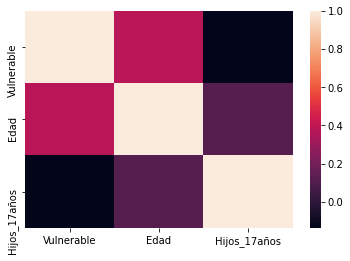

In [ ]:
corr = data_targ.corr(method='kendall')
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

In [ ]:
# sns.pairplot(data_targ)

## Etiquetando los strings

In [ ]:
data_targ['Requerimiento_Organizacional'] = pd.factorize(data_targ.Requerimiento_Organizacional)[0]
data_targ['Transporte'] = pd.factorize(data_targ.Transporte)[0]
data_targ['Vacunación'] = pd.factorize(data_targ.Vacunación)[0]

data_targ

,Vulnerable,Transporte,Vacunación,Edad,Requerimiento_Organizacional,Hijos_17años
0,0,0,0,56.0,0,0
1,0,0,1,46.0,0,0
2,0,0,1,49.0,0,0
3,0,0,1,NaN,0,0
4,0,0,1,47.0,0,1
...,...,...,...,...,...,...
349,0,0,1,NaN,2,0
350,1,0,1,NaN,2,0
351,1,0,1,NaN,2,0
352,1,0,1,NaN,2,0


In [ ]:
data_targ["Requerimiento_Organizacional"].value_counts()

2    169
1    133
0     52
Name: Requerimiento_Organizacional, dtype: int64

In [ ]:
data["Requerimiento Organizacional"].value_counts()

Remoto        169
Flotante      133
Presencial     52
Name: Requerimiento Organizacional, dtype: int64

In [ ]:
data_targ["Transporte"].value_counts()

0    296
1     58
Name: Transporte, dtype: int64

In [ ]:
data["Transporte"].value_counts()

Si    296
No     58
Name: Transporte, dtype: int64

In [ ]:
data_targ["Vacunación"].value_counts()

1    257
0     97
Name: Vacunación, dtype: int64

In [ ]:
data["Vacunación"].value_counts()

No    257
Si     97
Name: Vacunación, dtype: int64

## Eliminando/Sustituyendo NA's

In [ ]:
data_targ["Edad"] = data_targ['Edad'].fillna(np.mean(data_targ["Edad"]))
data_targ["Edad"] = round(data_targ["Edad"])
data_targ

,Vulnerable,Transporte,Vacunación,Edad,Requerimiento_Organizacional,Hijos_17años
0,0,0,0,56.0,0,0
1,0,0,1,46.0,0,0
2,0,0,1,49.0,0,0
3,0,0,1,43.0,0,0
4,0,0,1,47.0,0,1
...,...,...,...,...,...,...
349,0,0,1,43.0,2,0
350,1,0,1,43.0,2,0
351,1,0,1,43.0,2,0
352,1,0,1,43.0,2,0


# Definiendo los factores de riesgo

In [ ]:
Risk1 = data_targ['Vulnerable'].apply(lambda Vulnerable: 1/6 if Vulnerable == 1 else 0)
Risk2 = data_targ['Requerimiento_Organizacional'].apply(lambda Requerimiento_Organizacional: 1/6 if Requerimiento_Organizacional == 2 else 0)
Risk3 = data_targ['Hijos_17años'].apply(lambda Hijos_17años: 1/6 if Hijos_17años > 0 else 0)
Risk4 = data_targ['Vacunación'].apply(lambda Vacunación: 1/6 if Vacunación == 1 else 0)
Risk5 = data_targ['Transporte'].apply(lambda Transporte: 1/6 if Transporte == 1 else 0)
Risk6 = data_targ['Edad'].apply(lambda Edad: 1/6 if Edad >= 60 else 0)

risk_df = pd.concat([Risk1,Risk2,Risk3, Risk4, Risk5, Risk6] , axis=1)

risk_df.head()

,Vulnerable,Requerimiento_Organizacional,Hijos_17años,Vacunación,Transporte,Edad
0,0.0,0.0,0.000000,0.000000,0.0,0.0
1,0.0,0.0,0.000000,0.166667,0.0,0.0
2,0.0,0.0,0.000000,0.166667,0.0,0.0
3,0.0,0.0,0.000000,0.166667,0.0,0.0
4,0.0,0.0,0.166667,0.166667,0.0,0.0


In [ ]:
risk_df.columns

Index(['Vulnerable', 'Requerimiento_Organizacional', 'Hijos_17años',
       'Vacunación', 'Transporte', 'Edad'],
      dtype='object')

In [ ]:
data["Transporte"].value_counts()

Si    296
No     58
Name: Transporte, dtype: int64

In [ ]:
risk_df["Transporte"].value_counts()

0.000000    296
0.166667     58
Name: Transporte, dtype: int64

In [ ]:
data["Requerimiento Organizacional"].value_counts()

Remoto        169
Flotante      133
Presencial     52
Name: Requerimiento Organizacional, dtype: int64

In [ ]:
risk_df["Requerimiento_Organizacional"].value_counts()

0.000000    185
0.166667    169
Name: Requerimiento_Organizacional, dtype: int64

# Añadiendolos a la BD

In [ ]:
data_targ['Risk_Factors'] = risk_df.sum(axis=1)
data_targ['Risk_Factors'] = round(data_targ["Risk_Factors"]*100, 1)
data_targ.head()

,Vulnerable,Transporte,Vacunación,Edad,Requerimiento_Organizacional,Hijos_17años,Risk_Factors
0,0,0,0,56.0,0,0,0.0
1,0,0,1,46.0,0,0,16.7
2,0,0,1,49.0,0,0,16.7
3,0,0,1,43.0,0,0,16.7
4,0,0,1,47.0,0,1,33.3


# Primera propuesta de Clusters a traves de Score

In [ ]:
data_targ["Risk_Factors"].value_counts()

33.3    119
16.7    110
50.0     90
0.0      21
66.7     14
Name: Risk_Factors, dtype: int64

# Creación de Clústeres (Score) Etiquetados

In [ ]:
data_targ["Risk_Factors_Group"] = data_targ['Risk_Factors'].apply(lambda x: 'Ola-' + str(int(x)))
data_targ["Risk_Factors_Group"].value_counts()

Ola-33    119
Ola-16    110
Ola-50     90
Ola-0      21
Ola-66     14
Name: Risk_Factors_Group, dtype: int64

# Análisis de Clústeres (Score)

Text(0, 0.5, 'Frecuencia')

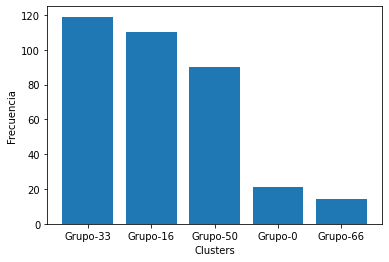

In [ ]:
y = data_targ['Risk_Factors'].apply(lambda x: 'Grupo-' + str(int(x)))
y

fig, ax = plt.subplots()
ax.bar(y.value_counts().index, y.value_counts())
ax.set_xlabel('Clusters')
ax.set_ylabel('Frecuencia')

Text(0.5, 1.0, 'Diagrama de Pie')

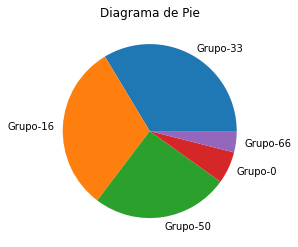

In [ ]:
fig, ax = plt.subplots()
ax.pie(y.value_counts(), labels = y.value_counts().index)
ax.set_title('Diagrama de Pie')

# Probando una regresión lineal multiple

In [ ]:
target = data_targ["Risk_Factors"]
dforreg = data_targ.drop(["Risk_Factors", "Risk_Factors_Group"], axis=1)

In [ ]:
reg_lin = sm.OLS(target, sm.add_constant(dforreg)).fit()
print(reg_lin.summary())

                            OLS Regression Results                            
Dep. Variable:           Risk_Factors   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     460.4
Date:                Thu, 22 Jul 2021   Prob (F-statistic):          7.02e-162
Time:                        17:59:22   Log-Likelihood:                -1101.1
No. Observations:                 354   AIC:                             2216.
Df Residuals:                     347   BIC:                             2243.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

# Scaling (Kmeans funcionality)

In [ ]:
dforscale = data_targ.drop(["Risk_Factors", "Risk_Factors_Group"], axis=1)

scaler = StandardScaler()
scaled = scaler.fit_transform(dforscale)
df_scaled = pd.DataFrame(scaled)

columns = ["Vulnerable", "Transporte", "Edad","Vacunación", "Requerimiento_Organizacional","Hijos_17años"]

df_scaled.columns = columns

df_scaled.head()

,Vulnerable,Transporte,Edad,Vacunación,Requerimiento_Organizacional,Hijos_17años
0,-0.396059,-0.442658,-1.627901,1.082501,-1.853914,-0.575972
1,-0.396059,-0.442658,0.597106,0.256271,-1.853914,-0.575972
2,-0.396059,-0.442658,0.597106,0.504140,-1.853914,-0.575972
3,-0.396059,-0.442658,0.597106,0.008402,-1.853914,-0.575972
4,-0.396059,-0.442658,0.597106,0.338894,-1.853914,0.765437


# Clusterings K-means con PCA

In [ ]:
data_kmeans = data_targ.drop(["Risk_Factors", "Risk_Factors_Group"], axis=1)

In [ ]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data_kmeans)
df_pca = pd.DataFrame(data = principalComponents
             , columns = ['component1', 'component2'])
df_pca.head()

,component1,component2
0,13.090880,-0.606684
1,3.082251,-0.587304
2,6.081575,-0.602294
3,0.082928,-0.572313
4,4.086542,0.394979


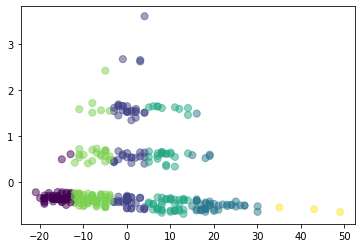

In [ ]:
kmeans = KMeans(n_clusters=6, max_iter=1000000).fit(df_pca)
y_labels = kmeans.labels_
y_kmeans = kmeans.predict(df_pca)

# centroids = kmeans.cluster_centers_

plt.scatter(df_pca['component1'], df_pca['component2'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
# plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

In [ ]:
data_targ["Cluster"] = y_kmeans
data_targ["Cluster"] = data_targ['Cluster'].apply(lambda x: 'Cluster-' + str(int(x)))
data_targ.head()

,Vulnerable,Transporte,Vacunación,Edad,Requerimiento_Organizacional,Hijos_17años,Risk_Factors,Risk_Factors_Group,Cluster
0,0,0,0,56.0,0,0,0.0,Ola-0,Cluster-3
1,0,0,1,46.0,0,0,16.7,Ola-16,Cluster-1
2,0,0,1,49.0,0,0,16.7,Ola-16,Cluster-3
3,0,0,1,43.0,0,0,16.7,Ola-16,Cluster-1
4,0,0,1,47.0,0,1,33.3,Ola-33,Cluster-1


In [ ]:
data_targ["Cluster"].value_counts()

Cluster-1    94
Cluster-4    89
Cluster-3    65
Cluster-0    59
Cluster-2    44
Cluster-5     3
Name: Cluster, dtype: int64

In [ ]:
data_targ[(data_targ.Cluster == "Cluster-0")].head(5)

,Vulnerable,Transporte,Vacunación,Edad,Requerimiento_Organizacional,Hijos_17años,Risk_Factors,Risk_Factors_Group,Cluster
28,0,0,1,28.0,0,1,33.3,Ola-33,Cluster-0
51,0,0,0,24.0,0,0,0.0,Ola-0,Cluster-0
53,0,0,1,24.0,0,0,16.7,Ola-16,Cluster-0
54,0,0,1,29.0,0,0,16.7,Ola-16,Cluster-0
57,0,0,1,26.0,1,0,16.7,Ola-16,Cluster-0


Text(0.5, 1.0, 'Diagrama de Pie')

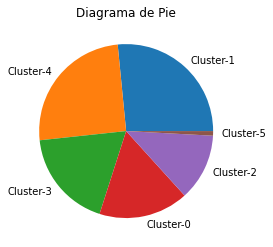

In [ ]:
y = data_targ['Cluster']

fig, ax = plt.subplots()

ax.pie(y.value_counts(), labels = y.value_counts().index)
ax.set_title('Diagrama de Pie')

In [ ]:
data_targ.head()

,Vulnerable,Transporte,Vacunación,Edad,Requerimiento_Organizacional,Hijos_17años,Risk_Factors,Risk_Factors_Group,Cluster
0,0,0,0,56.0,0,0,0.0,Ola-0,Cluster-3
1,0,0,1,46.0,0,0,16.7,Ola-16,Cluster-1
2,0,0,1,49.0,0,0,16.7,Ola-16,Cluster-3
3,0,0,1,43.0,0,0,16.7,Ola-16,Cluster-1
4,0,0,1,47.0,0,1,33.3,Ola-33,Cluster-1


# Función de Solución

In [ ]:
Indicador_Gobierno = int(input("¿Cual es el Aforo maximo permitido por el Gobierno "))

Aforo_Seguro = int()

if Indicador_Gobierno < 100:
  Aforo_Seguro = Indicador_Gobierno - (Indicador_Gobierno*0.10)
  print("Su Aforo Seguro es de " + str(round(Aforo_Seguro)) + "% del personal")
elif Indicador_Gobierno == 100:
  Aforo_Seguro = Indicador_Gobierno
  print("Su Aforo Seguro es de " + str(round(Aforo_Seguro)) + "% del personal")
else:
  print("El Aforo permitido no puede ser mayor al 100%")


Total_Empleados = data["ID"].count()

Total_Empleados = round((Total_Empleados*Aforo_Seguro)/100)
print("El numero total de empleados que pueden ingresar a sus oficinas es de:" + " " +  str(Total_Empleados))

Instruccion = "Y la distribución debera ser de la siguiente manera:"

print(Instruccion)

data_empresas = {'Empresa':  data["Empresa"].unique(),
        'Capacidad': [round(Total_Empleados*0.43),
                      round(Total_Empleados*0.07),
                      round(Total_Empleados*0.11),
                      round(Total_Empleados*0.3),
                      round(Total_Empleados*0.09)]}

Empresas = pd.DataFrame (data_empresas, columns = ['Empresa','Capacidad'])

data_pisos = {'Piso':  data["Piso"].unique(),
        'Capacidad': [round(Total_Empleados*0.22),
                      round(Total_Empleados*0.24),
                      round(Total_Empleados*0.26),
                      round(Total_Empleados*0.21),
                      round(Total_Empleados*0.03),
                      round(Total_Empleados*0.05)]}

Pisos = pd.DataFrame(data_pisos, columns = ['Piso','Capacidad'])

display(Empresas) 
display(Pisos)

¿Cual es el Aforo maximo permitido por el Gobierno 90
Su Aforo Seguro es de 81% del personal
El numero total de empleados que pueden ingresar a sus oficinas es de: 287
Y la distribución debera ser de la siguiente manera:


,Empresa,Capacidad
0,AOSA,123
1,MOLIERE,20
2,GRUPO BAL,32
3,TABAL,86
4,PETROBAL,26


,Piso,Capacidad
0,PB,63
1,Piso 5,69
2,Piso 6,75
3,Piso 7,60
4,Piso 8,9
5,Sótano 2,14


# Exportar resultados a CVS

In [ ]:
writer = pd.ExcelWriter('GRUPOBAL.xlsx', engine='xlsxwriter')


data_targ.to_excel(writer, sheet_name='Sheet1')
Empresas.to_excel(writer, sheet_name='Sheet2')
Pisos.to_excel(writer, sheet_name='Sheet3')
data.to_excel(writer, sheet_name='Sheet4')

writer.save()

In [ ]:
files.download("GRUPOBAL.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>